In [45]:
# Name: Yongqin Jian
# ID: 1472458
import numpy as np
import cv2
import os
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from google.colab import drive

# Utils

In [46]:
def add_noise(imgs):
    """
    Main function add noise to images.

    Here we load the dataset, add gaussian, poisson, speckle
    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    """
    row, col = 28, 28
    noisy_output = np.zeros((len(imgs), row, col))
    
    # adding noise
    for idx, img in enumerate(imgs):
        img = img.astype(np.float32)
        noise_type = random.choice(["gaussian", "speckle"])

        if noise_type == "gaussian":
            mean, var = -10, 100
            sigma = var**.5
            noise = np.random.normal(20, 10, img.shape)
            img += noise

        elif noise_type == "speckle":
            noise = np.random.randn(row,col)
            noise = noise.reshape(row,col)
            img += img * noise


        noisy_output[idx] = img
        
    return noisy_output

# Load and Split Data

In [47]:
# Loading the dataset from Keras
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=10000, random_state=42)

In [48]:
print(f"Number of Training Set datapoints: {len(xtrain)}")
print(f"Number of Validation Set datapoints: {len(xval)}")
print(f"Number of Test Set datapoints: {len(xtest)}")

Number of Training Set datapoints: 50000
Number of Validation Set datapoints: 10000
Number of Test Set datapoints: 10000


## Add Noise

In [49]:
"""
Split Data and Add Noise

We split the 50k training data into 2 sets where we add 1 type of noise to each set. 
"""
import random

# We define two types of noises
noise_types = ["gaussian","speckle"]

# adding noise to xtrain and xtest
noisy_xtrain = add_noise(xtrain)
noisy_xval = add_noise(xval)
noisy_xtest = add_noise(xtest)

## Visualize Noise

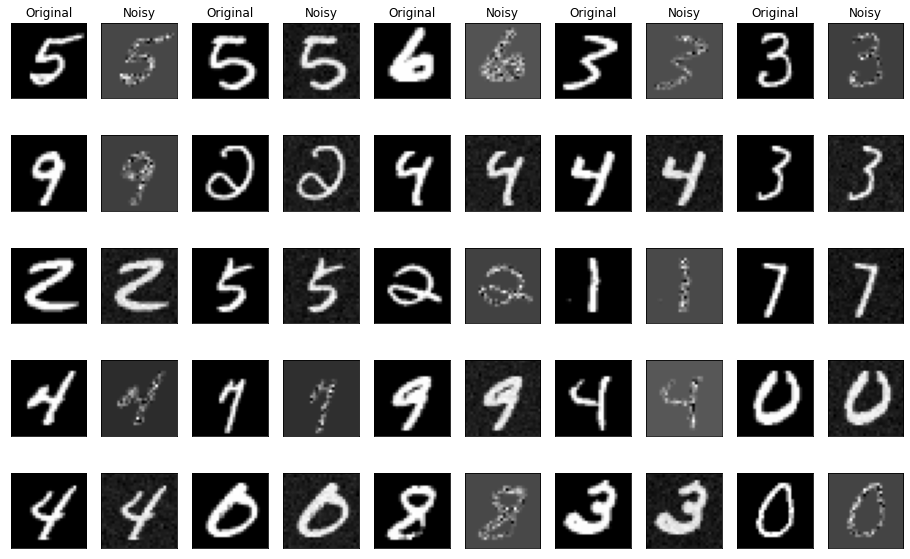

In [50]:
"""
Visualization of Original Image vs. Noisy Image.
"""
import itertools
f, axes = plt.subplots(5, 10, figsize=(16, 10))

for xid, yid in itertools.product(range(5), range(0, 10, 2)):
    image_id = random.randint(0, 50000)
    
    # display original image
    axes[xid, yid].imshow(xtrain[image_id],cmap="gray")
    axes[xid, yid].set(xticks = [], yticks = [])

    # display original image
    axes[xid, yid+1].imshow(noisy_xtrain[image_id],cmap="gray")
    axes[xid, yid+1].set(xticks = [], yticks = [])
    
    if xid == 0:
        axes[xid, yid].set(title = "Original")
        axes[xid, yid+1].set(title = "Noisy")

## Data Loader

In [51]:
"""
Dataset
"""
class noisedDataset(Dataset):
  
    def __init__(self, noisy_dataset, clean_dataset, labels, transform):
        self.noise = noisy_dataset
        self.clean = clean_dataset
        self.labels = labels
        self.transform = transform
  
    def __len__(self):
        return len(self.noise)
  
    def __getitem__(self,idx):
        noisy_x = self.noise[idx]
        clean_x = self.clean[idx]
        y = self.labels[idx]
    
        if self.transform != None:
            noisy_x = self.transform(noisy_x)
            clean_x = self.transform(clean_x)

        return (noisy_x, clean_x, y)  

In [52]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(noisy_xtrain, xtrain, ytrain, tsfms)
valset = noisedDataset(noisy_xval, xval, yval, tsfms)
testset = noisedDataset(noisy_xtest, xtest, ytest, tsfms)

In [53]:
batch_size = 32

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=True)


# Denoising Autoencoder (DAE) Model

In [54]:
#************************************** Documentation *************************** #
# In this DAE NoteBook, the main task is to denoise the input images 
# using autoencoder and output the denoised images correspondingly. The
# Denoising Autoencoder architecture is a nueral network.
#
# Pretty similar to the Part A, as a bottleneck structure, I first apply
# 3 layers for encode, and 3 decode layers after. At beginning I tried
# to use convolution and transpose convolution to achieve that denoising
# goal, however, under the "Visualize Denoising Test Set" section, the
# test dataset is a flatten type which mean the input would be (1,28*28)
# for each single image, whereas the convolution uses (1,28,28) as input.
# Thus that causes my model and training function raise errors. 
#
# My solution is adapted to linear nueral network in order to fit the 
# test set. SO my model takes 28*28 as input, and outputs 64 layers
# after encode. Then I decode using the same linear model back to 28*28
# In training function, I train each batch of noised data into my model,
# and check losses with the original data which is the xtrain rather than
# input data (noise data) because this is a denoising autoencoder, not
# just reconstruct to the noise data. A validation test follows each train
# to get epoch_loss data. There is no save model at this point because
# I think the model should be saved during test, and I do find the 
# save model code in test function. Also I think, based on the output
# loss decreaseing figure, the loss keep decreasing which means the model
# is improved rather than over-fit.
#
# ** A more detailed explaination about my code could be found inside ** 
# ** the code (besides the code or above each line of code)      **
# 
# ** Due to some error raised up during implementing and as I use
# ** Colab to finish this, I changed some lines of code to fit my
# ** implementation. They are:
# **  1.I changed save_model_local_for_submission so that I can save the
# **   model in colab during test
# **
# **  2.According to above entry, I import google.colab and mount the
# **   google drive at top of Training() fucntion
# **
# **  3.I commented "assert os.path.isdir('checkpoint')" in Run() for 
# **   easily save my model to google drive
# **
# **  4.Since I use GPU to train my model, when my model pass to 
# **   "Visualize Denoising Test Set", the noise is not stored on 
# **   GPU but my model is. That would rise illegal memory access
# **   error. So I added a new line there to set my model to 
# **   CPU to fit the input noise. Fortunately the running time
# **   for the test is totolly acceptible.
# ************************************************************************************ #

In [55]:
"""
Autoencoder model
"""
# TODO: Main model definition + any utilities or custom layers
class DAE(nn.Module):
    # ---------- TODO: code here ------------ #
  def __init__(self):
    super(DAE,self).__init__()
    # The encode layers
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)

    # The decode layers
    self.fc4 = nn.Linear(64,128)
    self.fc5 = nn.Linear(128,256)
    self.fc6 = nn.Linear(256,28*28)


  def forward(self,x):
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    x = nn.functional.relu(self.fc3(x))

    x = nn.functional.relu(self.fc4(x))
    x = nn.functional.relu(self.fc5(x))
    x = nn.functional.sigmoid(self.fc6(x))


    return x


# Training

In [56]:
"""
Main Train Script
"""
def train(train_dataloader, val_dataloader, device, config):
    # ** add code to mount google drive for model saving
    drive.mount('/content/drive')
    model = DAE().to(device)
    # epochs_loss is losses for epochs --> len(epochs_loss) = number of epochs
    epochs_loss = []
    # ---------- TODO: code here ------------ #
    # ** set up optimizer ** #
    num_epochs = config['num_epochs']
    lr = config['lr']
    optimizer = optim.Adam(model.parameters(),lr = lr,amsgrad=True)

    # ** training ** #
    # There is not much difference than previous assignment, just train  model with optimizer
    for epoch in range(num_epochs):
      valid_loss = 0.0
      train_loss = 0.0
      model.train() # set model to train mode
      for data in train_dataloader:
        noise,xtrain,_ = data   # split data to noise xtrain and target, and we dont use lables in this DAE

        # ** transform the noise and xtrain to flatten type
        noise = noise.view(noise.size(0),-1)
        xtrain = xtrain.view(xtrain.size(0),-1)
        noise = noise.to(device,dtype=torch.float)  # due to noising process, the noise changed to double type

        xtrain = xtrain.to(device)

        optimizer.zero_grad()
        output = model(noise)
        # we compare btw output with xtrain which is the original data, instead of lables
        loss = nn.functional.mse_loss(output,xtrain)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

      #epochs_loss.append(train_loss/len(train_dataloader))

      output=None
      noise=None
      # validation part, similar to above, but no backward and loss calculation needed
      model.eval()
      with torch.no_grad():
        for data in val_dataloader:
          noise,xvalid,_ = data
          noise = noise.view(noise.size(0),-1)
          xvalid = xvalid.view(xvalid.size(0),-1)
          noise = noise.to(device,dtype=torch.float)
          xvalid = xvalid.to(device)

          output = model(noise)
          loss = nn.functional.mse_loss(output,xvalid)
          valid_loss += loss.item()

      valid_loss = valid_loss/len(val_dataloader)
      epochs_loss.append(valid_loss)
      print('for epoch',epoch,' the train loss is',train_loss/len(train_dataloader))
      print('for epoch',epoch,' the valid loss is',valid_loss)

      print('\n')
    return model, epochs_loss

"""
Saving Model Script
"""
def save_model_local_for_submission(model):  # if you are running on your local machine
    #torch.save(model.to(torch.device("cpu")), 'checkpoint/model.pt')
    torch.save(model.state_dict(),'drive/My Drive/model.pt')

# Run

In [57]:
def run():
    # set parameters
    config = {
        'num_epochs': 100,
        'lr':0.001
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, epochs_loss = train(train_dataloader, val_dataloader, device, config)
    
    # save model in checkpoint dir
    #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    save_model_local_for_submission(model)
    
    return model, epochs_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


for epoch 0  the train loss is 0.027661479899918354
for epoch 0  the valid loss is 0.019575789355137384
/n


for epoch 1  the train loss is 0.01774998604583954
for epoch 1  the valid loss is 0.01698795973993838
/n


for epoch 2  the train loss is 0.01558601670324688
for epoch 2  the valid loss is 0.015607211214350537
/n


for epoch 3  the train loss is 0.01445022299385231
for epoch 3  the valid loss is 0.014755426677752984
/n


for epoch 4  the train loss is 0.013710583996335169
for epoch 4  the valid loss is 0.014984389351215214
/n


for epoch 5  the train loss is 0.013179086276847853
for epoch 5  the valid loss is 0.01442999611053965
/n


for epoch 6  the train loss is 0.012795662196378104
for epoch 6  the valid loss is 0.014052441352180903
/n


for epoch 7  the train loss is 0.012494225636534559
for epoch 7  the valid loss is 0.013756979121360927
/n


for epoch 8  the train loss is 0.012321494924892467
for epoch 8  the valid loss is 0.013868479635706171
/n


for epoch 9  the train l

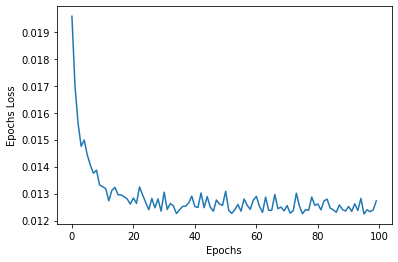

In [58]:
def main():
    
    model, epochs_loss = run()
    
    # plot loss in each epoch
    plt.plot(range(len(epochs_loss)), epochs_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Epochs Loss')
    
    return model
    
model = main()

# Visualize Denoising Test Set

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


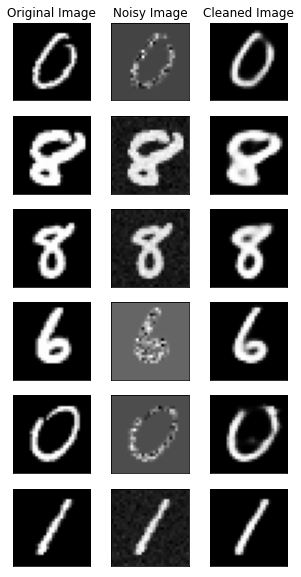

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to("cpu") # ** I convert model to CPU to fit the test set below ** #
f, axes= plt.subplots(6, 3, figsize = (5, 10))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Noisy Image")
axes[0,2].set_title("Cleaned Image")

for idx, (noisy, clean, label) in enumerate(test_dataloader):
    if idx > 5:
        break
    
    # denoising with DAE
    noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
    #print(noisy.is_cuda)
    # this line must be commented to avoid illegal memory access error
    #noisy = noisy.to(device)
    output = model(noisy)
    
    # fix size
    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()
    
    noisy = noisy.view(1, 28, 28)
    noisy = noisy.permute(1, 2, 0).squeeze(2)
    
    # this line must be commented to avoid illegal memory access error
    # noisy = noisy.detach().cpu().numpy()

    clean = clean.view(1, 28, 28)
    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()
    
    # plot
    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(noisy, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    
    axes[idx, 0].set(xticks=[], yticks=[])
    axes[idx, 1].set(xticks=[], yticks=[])
    axes[idx, 2].set(xticks=[], yticks=[])

# Evaluation with Peak Signal to Noise Ratio (PSNR) Metric

In [60]:
def evaluate(model, test_dataloader):
    psnr_noisy = []
    psnr_clean = []
    for noisy, original, label in tqdm(test_dataloader):
        # denoising with DAE
        noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
        
        # this line must be commented to avoid illegal memory access error
        # noisy = noisy.to(device)
        clean = model(noisy)

        # fix size
        clean = clean.view(1, 28, 28)
        clean = clean.permute(1, 2, 0).squeeze(2)
        clean = clean.detach().cpu().numpy()

        noisy = noisy.view(1, 28, 28)
        noisy = noisy.permute(1, 2, 0).squeeze(2)
        noisy = noisy.detach().cpu().numpy()

        original = original.view(1, 28, 28)
        original = original.permute(1, 2, 0).squeeze(2)
        original = original.detach().cpu().numpy()
        
        psnr_noisy.append(cv2.PSNR(noisy, original))
        psnr_clean.append(cv2.PSNR(clean, original))
        
    return np.mean(psnr_noisy), np.mean(psnr_clean)

In [61]:
psnr_noisy, psnr_clean = evaluate(model, test_dataloader)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 10000/10000 [00:05<00:00, 1838.26it/s]


In [62]:
print(f'PSNR improved from {psnr_noisy} for Noisy Images to {psnr_clean} for denoised images by DAE.')

PSNR improved from 7.751414332621947 for Noisy Images to 67.90029069965215 for denoised images by DAE.
